# IFT-712 Semester Project

Team Members
------------------------------
IDRISSI Ismail (idri3201)  
SHAWN Vosburg (voss2502)



# Data Exploration
We will be exploring the data in this notebook to find clues as per its distribution. We first start by importing the data.

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
import sys
sys.path.append("..")
from src.DataManagement.Manager import DataManager
%reload_ext autoreload
%autoreload 2


dm = DataManager(seed = 16082604)
dm.importData(label_name = 'species')
print(f"The total dataset is composed of {dm.df.shape[0]} observations with dimentionality {dm.df.shape[1]}.")
dm.df.head()

The total dataset is composed of 990 observations with dimentionality 192.


,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
id,,,,,,,,,,,,,,,,,,,,,
1,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
2,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
3,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
5,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
6,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


If there were no errors above, then loading the data worked.   

## Datasets Distributions
We will now be looking at the data at the species-level.

In [2]:
def classDistributions(data: pd.DataFrame, classes: pd.Series):
    """
    Computes helpful distribution statistics about dataset
    """
    species = set(classes)
    maxNumObs = max([len(data[classes == s]) for s in species])
    minNumObs = min([len(data[classes == s]) for s in species])
    print(f'There are {len(species)} species (i.e. classes) in the dataset.')
    print(f'Each classes has a minimum of {minNumObs} and a maximum of {maxNumObs} observations.')

classDistributions(dm.df, dm.labels)

There are 99 species (i.e. classes) in the dataset.
Each classes has a minimum of 10 and a maximum of 10 observations.


We have determined that each classes contain **10 observations** before splitting the data into train and test datasets for cross validation. Now, let's split the dataset (with the seed = 16082604 as used during the project) and check the classes' distribution afterwards.

In [3]:
dm.split_data(test_ratio = 0.1)
print("Train + Validation dataset:")
classDistributions(dm.df_Train, dm.labels_Train)

Train + Validation dataset:
There are 99 species (i.e. classes) in the dataset.
Each classes has a minimum of 4 and a maximum of 10 observations.


In [4]:
print("Test dataset:")
classDistributions(dm.df_Test, dm.labels_Test)

Test dataset:
There are 93 species (i.e. classes) in the dataset.
Each classes has a minimum of 1 and a maximum of 6 observations.


**Sanity Check**  
Verify that every class in the test set is also present in the Train + Validation set

In [5]:
diffSets = set(dm.labels_Test) - set(dm.labels_Train)
if(diffSets == set()):
    print("Sanity Check PASSED!")
else:
    print("Sanity Check FAILED!")
    raise ValueError("There are no training observations for classes "+ str(diffSets))

Sanity Check PASSED!


## 1) 2-D PCA Visualisation

We want to try to visualise the classes distributions with PCA. We will first preprocess the data with sklearn's StandardScaler to normalize mean and variance of all variables. A 2-D graph with the 2 top principal components will then be generated. These components represent vectors in our 192-dimensional space that has the greatest variance. 

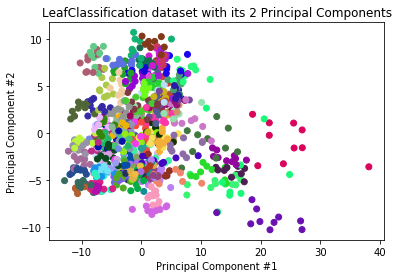

In [7]:
np.random.seed(0)
species = list(set(dm.labels))
colorIdxs = list(map(lambda x: species.index(x), dm.labels))
cmap = [np.random.rand(3,) for _ in range(len(colorIdxs))]
colors = [cmap[idx] for idx in colorIdxs]

pca = PCA(n_components=2)
scaler = StandardScaler()
standardScalerData = scaler.fit_transform(dm.df)
pcaData = pca.fit_transform(standardScalerData)


plt.scatter(pcaData[:,0],pcaData[:,1], c = colors )
plt.title("LeafClassification dataset with its 2 Principal Components")
plt.xlabel("Principal Component #1")
plt.ylabel("Principal Component #2")
plt.show()

With just the top 2 principal components (from a total of 192 principal components), we can already see some classes starting to seperate from the rest. More investigation is needed to determine the level of linear seperability.

# 2) Determine which class is seperable with a hypersphere

From the previous experiment, it is clear that some classes, after preprocessing with sklearn's StandardScaler, are seperable. To determine which class definitely is seperable in feature space, we can use the following algorithm:

1. Calculate class center for each class
2. Find the farthest point of each class belonging to that same class.
3. Find the closest point of each class belonging to a different class.
4. If the distance from step 2 is smaller than the distance from step 3, the class is linearly seperable.

We are essentially determining if a sphere can be placed around the class cluster that will isolate it from other classes.

We will be using this algorithm with unprocessed data, SciKit-Learn's StandardScaler and MinMixScaler. The MinMaxScaler is set to map all dimentions into a range [0,1].

In [122]:
def classesSeperable(data: pd.DataFrame, labels: pd.DataFrame):
    """
    Determines which classes can be seperated by a sphere around the class's cluster. Useful to definitely determine
    if a class is seperable.
    """
    speciesList = list(set(labels))

    #Seperating Data into individual classes
    speciesData = []
    for species in speciesList:
        indexes = labels[labels == species].index
        speciesData.append(data.loc[indexes])

    #Step 1. Finding mean of each data
    averages = [df.values.mean(axis = 0) for df in speciesData]

    #Step 2. Finding the fathest point's distance from same class
    maxDistIntraList = [max(np.linalg.norm(classData - avg, axis = 1)) for classData, avg in zip(speciesData, averages)]

    #Step 3. Finding the closest point from another class's distance 
    maxDistInterList = []
    for classData, avg in zip(speciesData, averages):
        minVal = min(np.linalg.norm(data.drop(classData.index) - avg, axis = 1))
        maxDistInterList.append(minVal)

    #Step 4. Print number of classes that are can be seperated 
    #        by englobing the class cluster with a sphere in feature space
    seperableClasses = []
    for className, maxDistIntra, minDistInter in zip(speciesList, maxDistIntraList, maxDistInterList):
        if(maxDistIntra < minDistInter):
            seperableClasses.append(className)
    return seperableClasses

In [123]:
#From the unprocessed dataset, how many classes are seperable?
seperableClasses = classesSeperable(data = dm.df, labels = dm.labels)
print(f"Without Sklearn's StandardScaler, There are definitely {len(seperableClasses)} seperable classes in higher dimentions.")

#With SKlearn's MinMaxScaler, how many classes are seperable?
preprocessedData = pd.DataFrame(MinMaxScaler().fit_transform(dm.df), index = dm.df.index)
seperableClasses = classesSeperable(data = preprocessedData , labels = dm.labels)
print(f"With Sklearn's MinMaxScaler, There are definitely {len(seperableClasses)} seperable classes in higher dimentions.")

#With SKlearn's StandardScaler, how many classes are seperable?
preprocessedData = pd.DataFrame(StandardScaler().fit_transform(dm.df), index = dm.df.index)
seperableClasses = classesSeperable(data = preprocessedData , labels = dm.labels)
print(f"With Sklearn's StandardScaler, There are definitely {len(seperableClasses)} seperable classes in higher dimentions.")


Without Sklearn's StandardScaler, There are definitely 26 seperable classes in higher dimentions.
With Sklearn's MinMaxScaler, There are definitely 76 seperable classes in higher dimentions.
With Sklearn's StandardScaler, There are definitely 68 seperable classes in higher dimentions.


From the dataset alone, **26/99 classes** are already seperable (not necessarly linearly seperable, but can definitely be seperated by a sphere).  
By adding the MinMaxScaler, we obtain **76/99** classes that are seperable.  
By adding the StandardScaler preprocessing step, we obtain **68/99** classes that are seperable.

This experiment demonstrates how useful preprocessing is. Since so many classes are sperable with a hyper-sphere, our team hypothesize that a linear classifier with polynomial features (or a kernel replacing these features) will be successful at classifying these seperable classes. This stems from hyperspheres being defined as:
    
    C = sqrt(x1^2 + x2^2 + ... + xd^2)
where C is a constant, and xn is a dimention in d-dimentional space.